# Average Bubble

In [1]:
from bubble_tools import *
from experiment import *
from plotting import *

from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_widths

V3 = lambda x, la:  ( -np.cos(x) + 0.5 * la**2. * np.sin(   x)**2.) * 4. * nu


In [2]:
minSim = 0
maxSim = 2500

tmp = 0
temp = tempList[tmp]

lamb = lambList[tmp]
sigmafld = fluct_stdev(lamb, phi0, temp)

velsplit = 0.89


In [5]:
all_data = []
for sim in range(minSim, maxSim):      
    path_clean_sim = clean_sim_location(nLat, lamb, phi0, temp, sim)
    loc_rest_bub = bubble_at_rest(nLat, lamb, phi0, temp, sim)+'.npy'
    if os.path.exists(loc_rest_bub):
        sim, real, totalvCOM, finalv = np.load(loc_rest_bub)
        if np.abs(totalvCOM) < velsplit:
            all_data.append(np.asarray([real, totalvCOM, sim]))


190


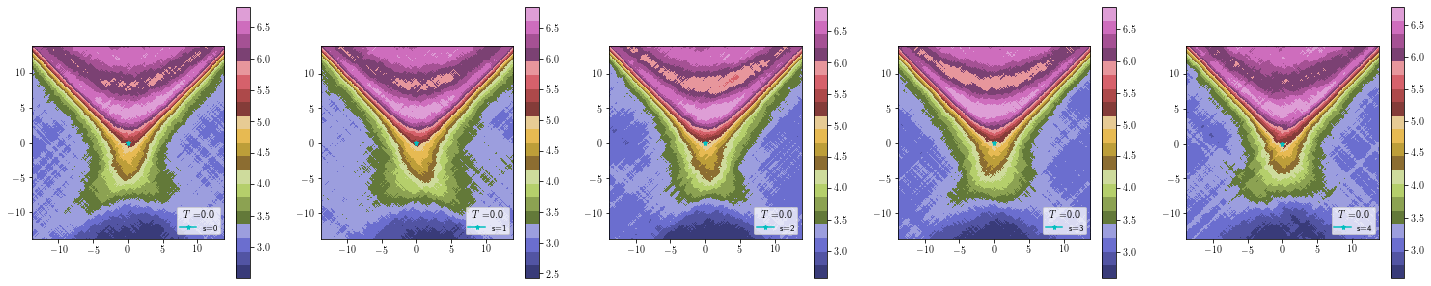

In [6]:
if True:
    right_Vmax  = sco.minimize_scalar(Vinv, args=lamb, bounds=(np.pi, 2*np.pi), method='bounded')
    left_Vmax   = sco.minimize_scalar(Vinv, args=lamb, bounds=(0    ,   np.pi), method='bounded')
    crit_thresh = right_Vmax.x+2.*sigmafld

    win = 200
    critSize = 20

    nS = len(all_data); print(nS)
    asim, bsim = np.arange(4+1)*nS//5, np.arange(1, 5+1)*nS//5

    if False:
        for ind, (i, j) in enumerate(zip(asim, bsim)):
            print(i, j)
            part_data = all_data[i:j]
            stacks  = stack_bubbles(part_data, False, win, phieq, crit_thresh, critSize)
            stacks  = average_stacks(stacks, False, normal)
            avstack = average_bubble_stacks(stacks)

            np.save(average_bubble_file(nLat, lamb, phi0, temp)+'split'+str(5)+'ind'+str(ind)+'velsplit'+str(velsplit), avstack)
            print('Done', j, nS)

    bubbleList = np.zeros((5, 2, 3, 2*win+1, 2*win+1))
    for ind, (i, j) in enumerate(zip(asim, bsim)):
        bubbleList[ind] = np.load(average_bubble_file(nLat, lamb, phi0, temp)+'split'+str(5)+'ind'+str(ind)+'velsplit'+str(velsplit)+'.npy')

    fig, ax = plt.subplots(1, 5, figsize = (5*5, 5))
    for ind, (i, j) in enumerate(zip(asim, bsim)):
        average_bubble = bubbleList[ind]
        bubble = average_bubble[0,0]
        nT, nN = np.shape(bubble)
        tcen, xcen  = find_nucleation_center2(bubble, phieq, crit_thresh, critSize)
        tl, tr      = max(0, tcen-win//2), min(nT-1, tcen+win//2)
        xl, xr      = max(0, xcen-win//2), min(nN-1, xcen+win//2)
        ext         = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*dx2plot
        bubble2plot = average_bubble[0,0][tl:tr,xl:xr]

        im0  = ax[ind].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
        clb0 = plt.colorbar(im0, ax = ax[ind])
        ax[ind].plot(0, 0, color='c', marker='*', ms='5', label='s='+str(ind))
        ax[ind].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
    plt.show()


(3, 301, 281)
(3, 301, 281)
(3, 301, 281)
(3, 301, 281)
(3, 301, 281)


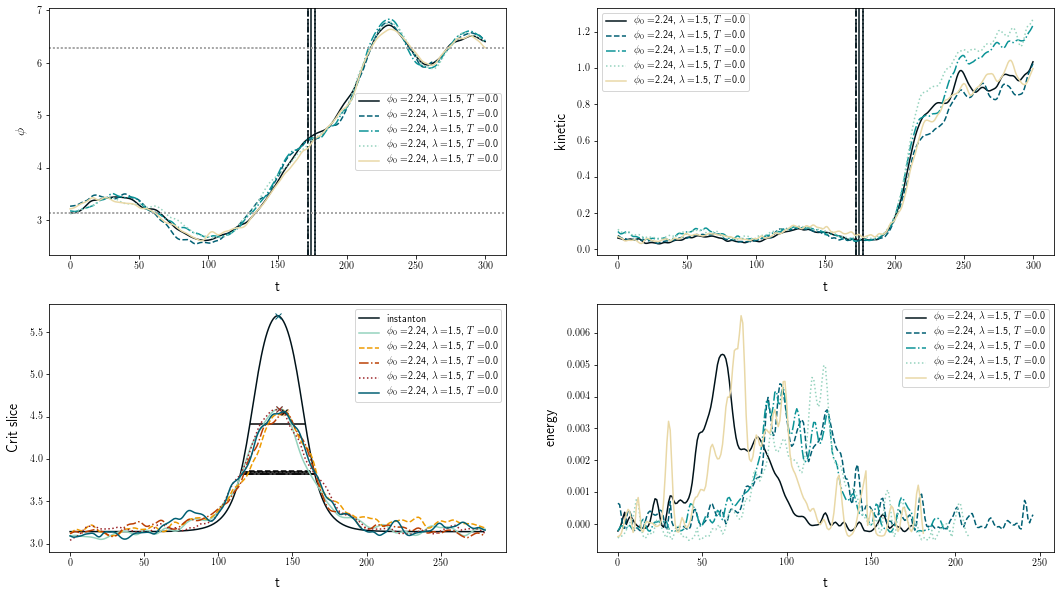

In [11]:
indList = []

fig, ax = plt.subplots(2, 2, figsize = (18, 10))
for ii, average_bubble in enumerate(bubbleList):
    bubble2plot = average_bubble[0, :, :-100, 60:-60]
    for bi, jk in enumerate(bubble2plot[:]):
        bubble2plot[bi] = gaussian_filter(jk, 1, mode='nearest')

    print(np.shape(bubble2plot))
    nT,nN = np.shape(bubble2plot[0])

    kinetic    = 0.5*bubble2plot[1]**2.
    gradient   = 0.5*bubble2plot[2]**2.
    potential  = V3(bubble2plot[0], lamb) - V3(2.*phieq, lamb)
    totEbubble = kinetic + gradient + potential

    kinprof   = np.trapz(kinetic, dx=dx, axis=1)
    potenprof = np.trapz(potential, dx=dx, axis=1)
    gradprof  = np.trapz(gradient, dx=dx, axis=1)
    enprof    = np.trapz(totEbubble, dx=dx, axis=1)

    off = 150
    indmin  = np.argmin(kinprof[off:]) + off

    slice    = bubble2plot[0,indmin]
    momslice = bubble2plot[1,indmin]
    enslice  = totEbubble[indmin]

    xmax = np.argmax(slice)
    phiprof = bubble2plot[0,:,xmax+1]

    bubbleCoords = slice>=phieq*1.008
    bubbleCoordsNot = slice<phieq*1.008

    ensliceBub = enslice*bubbleCoords
    ensliceBub = ensliceBub[np.argwhere(ensliceBub>0)].flatten()
    ensliceBubNot = enslice*bubbleCoordsNot
    ensliceBubNot = ensliceBubNot[np.argwhere(ensliceBubNot>0)].flatten()
    enslice = ensliceBub - np.mean(ensliceBubNot)
    Eemp = np.trapz(ensliceBub, dx=dx)

    indList.append(indmin)

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ['-', '--', '-.', ':', '-']

    if ii==0:
        instanton = np.load(path_inst(nLat, lamb, phi0, temp)+'.npy')
        instanton = instanton[np.argmax(instanton)-len(slice)//2:np.argmax(instanton)+len(slice)//2]
        ax[1,0].plot(instanton, ls=lsl[ii], label='instanton')
        peaks, _ = find_peaks(instanton)
        ind = np.argmax(instanton[peaks])
        fwhm = peak_widths(instanton, peaks, rel_height=0.5)
        ax[1,0].plot(peaks, instanton[peaks], "x")
        ax[1,0].hlines(*fwhm[1:], ls=lsl[ii])

    peaks, _ = find_peaks(slice, height=phieq)
    ind = np.argmax(slice[peaks[:]])
    fwhm = peak_widths(slice, peaks[[ind]], rel_height=0.5)
    ax[1,0].plot(peaks[[ind]], slice[peaks[[ind]]], "x")
    ax[1,0].hlines(*fwhm[1:], ls=lsl[ii])

    ax[0,0].plot(phiprof, ls=lsl[ii], label=labs)
    ax[0,0].axhline(phieq, ls=':', color='darkgray')
    ax[0,0].axhline(2.*np.pi, ls=':', color='darkgray')
    ax[0,0].axvline(indmin, ls=lsl[ii])
    ax[0,1].axvline(indmin, ls=lsl[ii])
    ax[0,1].plot(kinprof, ls=lsl[ii], label=labs)
    ax[1,0].plot(slice, ls=lsl[ii], label=labs)
    ax[1,1].plot(enslice, ls=lsl[ii], label=labs)

    for aa, axx in enumerate(ax.flatten()):
        axx.set_ylabel([r'$\phi$', 'kinetic', 'Crit slice', 'energy'][aa])
        axx.set_xlabel('t')
        axx.legend()
plt.show()

141
34
146
2
145
3
141
9
144
59


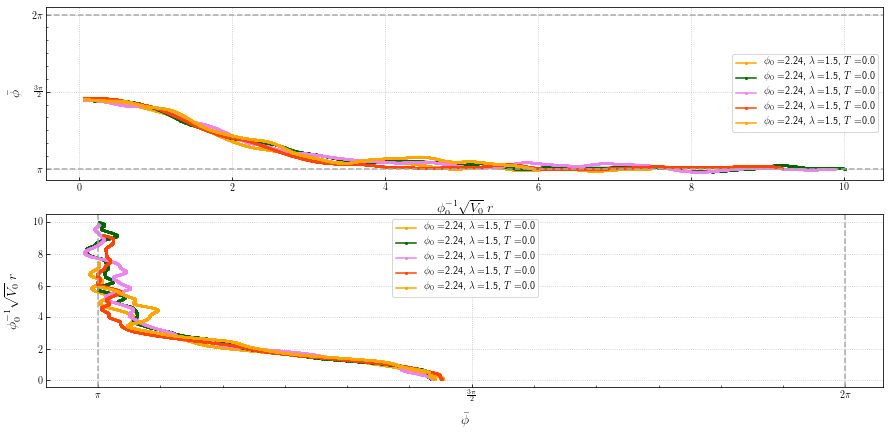

In [31]:
fig, ax = plt.subplots(2, 1, figsize = (15, 7))
cols = cycle(['orange', 'darkgreen', 'violet', 'orangered'])

fvrecoList = []
for ii, average_bubble in enumerate(bubbleList):

    indmin = int(indList[ii])
    col = next(cols)

    data = average_bubble[0,0,indmin, 60:-60]

    xpeak  = np.argmax(data); print(xpeak)
    data   = data[:xpeak+1]

    xstart = np.argwhere(data>phieq).flatten()[0]; print(xstart)

    data   = data[xstart:]
    data   = data[::-1]
    xlist  = np.linspace(1., len(data), len(data))*dx2plot
    ax[0].plot(xlist, data, color=col, ls='-')

    spline     = scp.interpolate.splrep(xlist, data)    # interpolate mean field
    der1spline = scp.interpolate.splder(spline, n=1)    # take tangent to this curve
    der2spline = scp.interpolate.splder(spline, n=2)    # take tangent to tangent curve

    rr = np.linspace(xlist[0], xlist[-1], 1000)
    phifv    = scp.interpolate.splev(rr, spline)
    dphidr   = scp.interpolate.splev(rr, der1spline)
    ddphiddr = scp.interpolate.splev(rr, der2spline)

    if temp==0:
        dVdr = scp.interpolate.splrep(rr, (ddphiddr + dphidr/(rr/np.sqrt(4*nu)))*dphidr )
        #dVdr = scp.interpolate.splrep(rr, (ddphiddr + dphidr/rr)*dphidr )
    else:
        dVdr = scp.interpolate.splrep(rr, ddphiddr*dphidr )

    Vantider = scp.interpolate.splantider(dVdr, n=1)
    Vofrofphi = scp.interpolate.splev(rr, Vantider)

    fvrecoList.append(np.asarray([tmp, temp, lamb, phi0, rr, phifv, dphidr, ddphiddr, Vofrofphi]))

    labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax[0].plot(rr, phifv, color=col, ls=None, marker='o', ms=2, label=labs)
    ax[1].plot(phifv, rr, color=col, ls=None, marker='o', ms=2, label=labs)

ax[0].set_ylabel(r'$\bar{\phi}$')
ax[0].set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
ax[1].set_ylabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
ax[1].set_xlabel(r'$\bar{\phi}$')

ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[1].xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

ax[0].axhline(np.pi, ls='--', color='darkgray')
ax[0].axhline(2.*np.pi, ls='--', color='darkgray')
ax[1].axvline(np.pi, ls='--', color='darkgray')
ax[1].axvline(2.*np.pi, ls='--', color='darkgray')

for axx in ax:
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.grid(ls=':', color='gray', alpha=0.5)
    axx.legend()
plt.show()

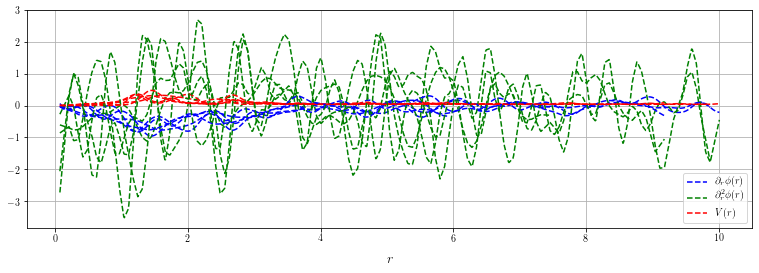

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (13, 4))
for ii, lists in enumerate(fvrecoList):
    tmp, temp, lamb, phi0, rinv, phifv, dphidr, ddphiddr, Vofrofphi = lists

    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')
    ax.plot(rinv, dphidr, 'b', ls=lsl, label=(f'$\partial_r \phi(r)$' if ii==0 else None))
    ax.plot(rinv, ddphiddr, 'g', ls=lsl, label=(f'$\partial_r^2 \phi(r)$' if ii==0 else None))
    ax.plot(rinv, Vofrofphi, 'r', ls=lsl, label=(f'$V(r)$' if ii==0 else None))

ax.set_xlabel(r'$r$'); ax.legend(); ax.grid(); plt.show()


# The Roll 

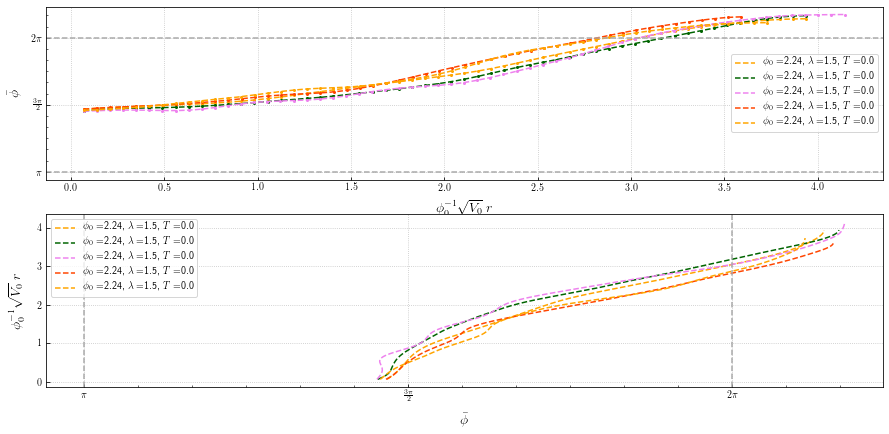

In [33]:
if True:
    fig, ax = plt.subplots(2, 1, figsize = (15, 7))
    cols = cycle(['orange', 'darkgreen', 'violet', 'orangered'])

    rollrecoList = []
    for ii, average_bubble in enumerate(bubbleList):

        indmin = int(indList[ii])

        col = next(cols)
        off = 1
        xpeak = np.argmax(average_bubble[0,0,indmin+off])
        data  = average_bubble[0,0][:, xpeak]
        data  = data[indmin+off:]

        tstop = np.argmax(data)
        data  = data[:tstop+1]

        tlist = (off + np.linspace(0, len(data), len(data)))*dt2plot

        spline     = scp.interpolate.splrep(tlist, data)    # interpolate mean field
        der1spline = scp.interpolate.splder(spline, n=1)    # take tangent to this curve
        der2spline = scp.interpolate.splder(spline, n=2)    # take tangent to tangent curve

        rt       = np.linspace(tlist[0], tlist[-1], 1000)
        phiroll  = scp.interpolate.splev(rt, spline)
        dphidr   = scp.interpolate.splev(rt, der1spline)
        ddphiddr = scp.interpolate.splev(rt, der2spline)

        # integrate product of derivatives above to get potential function of r
        dVdr = scp.interpolate.splrep(rt, - (ddphiddr + dphidr/(rt/np.sqrt(4*nu)))*dphidr )
        #dVdr = scp.interpolate.splrep(rt, - (ddphiddr + dphidr/rt)*dphidr )

        Vantider = scp.interpolate.splantider(dVdr, n=1)
        Vofrofphi = scp.interpolate.splev(rt, Vantider)

        rollrecoList.append(np.asarray([tmp, temp, lamb, phi0, rt, phiroll, dphidr, ddphiddr, Vofrofphi]))

        labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
        lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

        ax[0].plot(tlist, data , color=col, ls='None', marker='o', ms=2)
        ax[0].plot(rt, phiroll, color=col, ls=lsl, label=labs)
        ax[1].plot(phiroll, rt , color=col, ls=lsl, label=labs)

    ax[0].set_ylabel(r'$\bar{\phi}$')
    ax[0].set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
    ax[1].set_ylabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$')
    ax[1].set_xlabel(r'$\bar{\phi}$')

    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[0].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[1].xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    ax[0].axhline(np.pi, ls='--', color='darkgray')
    ax[0].axhline(2.*np.pi, ls='--', color='darkgray')
    ax[1].axvline(np.pi, ls='--', color='darkgray')
    ax[1].axvline(2.*np.pi, ls='--', color='darkgray')

    for axx in ax:
        axx.tick_params(which='both', axis="y", direction="in")
        axx.tick_params(which='both', axis="x", direction="in")
        axx.grid(ls=':', color='gray', alpha=0.5)
        axx.legend()
    plt.show()


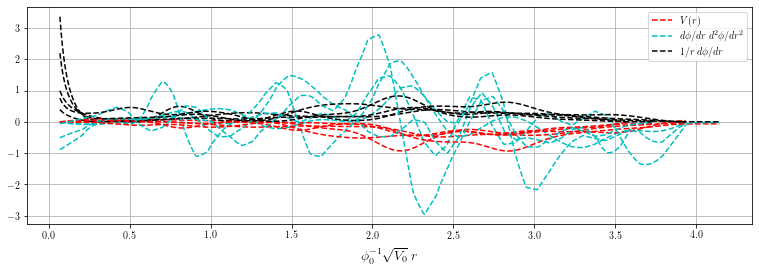

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (13, 4))
for ii, lists in enumerate(rollrecoList):
    tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vofrofphi = lists

    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax.plot(ts, Vofrofphi       , 'r', ls=lsl, label=(f'$V(r)$' if ii==3 else None))
    ax.plot(ts, dphidr*ddphiddr , 'c', ls=lsl, label=(f'$d\phi/dr \; d^2\phi/dr^2$' if ii==3 else None))
    ax.plot(ts, dphidr**2./ts   , 'k', ls=lsl, label=(f'$1/r \; d\phi/dr$' if ii==3 else None))

ax.set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$'); ax.legend(); ax.grid(); plt.show()


# Full reconstruction

In [35]:
fit_to_V = lambda x, la, a,c: ( -np.cos(x) + 0.5 * la**2. * np.sin(x)**2. - a) * c


In [36]:
    # compare:
    def m2reno(ii=0):
        temp     = tempList[ii]
        lamb     = lambList[ii]
        sigmafld = fluct_stdev(lamb, phi0, temp)
        m2u = lamb**2. - 1.

        kUV = 2.*np.pi/lenLat*(knyq-1 + 0.5)
        kIR = np.pi/lenLat

        sigmasqreno = np.log((kUV+np.sqrt(kUV**2.+m2u))/(kIR+np.sqrt(kIR**2.+m2u)))
        sigmasqreno = sigmasqreno/phi0**2./2./np.pi
        ddddV = 4.*lamb**2. - 1.
        m2reno = m2u - 0.5*sigmasqreno*ddddV
        return m2reno*4.*nu


1.2866413353337915 0.9953365769738396 1.401812791536103
Bare mass, curvature mass, lattice reno mass: 0.01 0.0073504592507249444 0.007975083226439155
1.2911729843684225 0.9965952106582208 1.2262953328363664
Bare mass, curvature mass, lattice reno mass: 0.01 0.006544728617593888 0.007975083226439155
1.2677124602823528 0.9981783963928823 1.441924900595189
Bare mass, curvature mass, lattice reno mass: 0.01 0.007003041482582082 0.007975083226439155
1.297735834050612 0.9952143252527427 1.3488221531596964
Bare mass, curvature mass, lattice reno mass: 0.01 0.00738199140623264 0.007975083226439155
1.2784773297302088 1.0293155395787028 1.433470223151632
Bare mass, curvature mass, lattice reno mass: 0.01 0.007276303052808732 0.007975083226439155


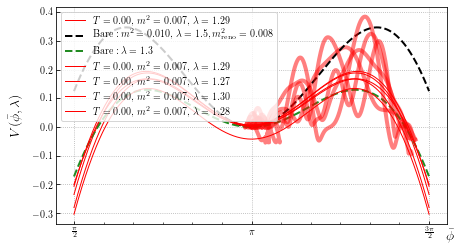

In [37]:
    fig, ax = plt.subplots(1, 1, figsize = (7, 4))
    extphi = np.linspace(phieq/2., np.pi*3./2., 800)
    cmap1 = get_cmap(5)
    cmapsp = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
    cych = cycle([cmap1(0), 'forestgreen', 'orangered', cmapsp[4]])

    col = next(cych)

    for ii in range(len(rollrecoList)):
        tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]
        Vfvofrofphi = Vfvofrofphi - Vfvofrofphi[np.argmin(np.abs(phifv-np.pi))]

        plt.plot(phifv, Vfvofrofphi, color=col, alpha=0.5, linewidth=4)

        xlist = phifv
        curve = Vfvofrofphi
        popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)

        curve2 = Vfvofrofphi*(4.*nu)
        popt2, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve2)
        spline = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt2))
        seconder = scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

        print(*popt)
        print('Bare mass, curvature mass, lattice reno mass:', m2(lamb), seconder, m2reno())
        plt.plot(extphi, fit_to_V(extphi, *popt), color=col, linewidth=1, label=r'$T=%5.2f, \, m^2=%5.3f, \, \lambda=%5.2f$'%(temp, seconder, popt[0]))

        extpos = extphi[extphi>phieq]
        aM = np.argmax(fit_to_V(extpos, *popt))

        if ii==0:
            plt.plot(extphi, V2(extphi, lamb)-1., ls=('--' if lamb==1.5 else '-'), linewidth=2, color='k', label=r'${\rm Bare: \,}$'+r'$m^2=%5.3f, \, \lambda=%5.1f, m^2_{\rm reno}=%5.3f$'%(m2(lamb),lamb,m2reno()))
            plt.plot(extphi, V2(extphi, popt[0])-1., ls=('--' if lamb==1.5 else '-'), linewidth=2, color='forestgreen', label=r'${\rm Bare: \,}$'+r'$\lambda=%5.1f$'%(popt[0]))


    plt.grid(True, ls=':', color='darkgray')
    plt.xlabel(r'$\bar{\phi}$'); plt.ylabel(r'$V(\bar{\phi}, \lambda)$')
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")
    ax.xaxis.set_label_coords(1.01, -0.02)
    plt.legend()
    plt.savefig('./data/effectiveV_bounce_reconstruction.pdf', rasterize=True)
    plt.show()

1.2866413353337915 0.9953365769738396 1.401812791536103
Bare mass, curvature mass, lattice reno mass: 0.01 0.0073504592507249444 0.007975083226439155


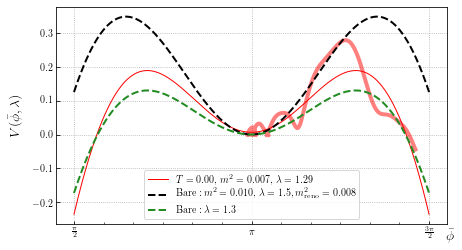

1.2911729843684225 0.9965952106582208 1.2262953328363664
Bare mass, curvature mass, lattice reno mass: 0.01 0.006544728617593888 0.007975083226439155


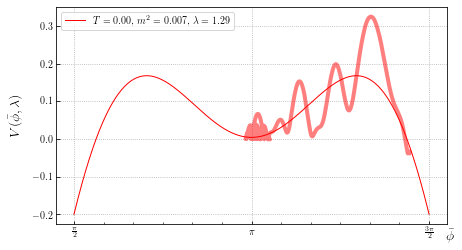

1.2677124602823528 0.9981783963928823 1.441924900595189
Bare mass, curvature mass, lattice reno mass: 0.01 0.007003041482582082 0.007975083226439155


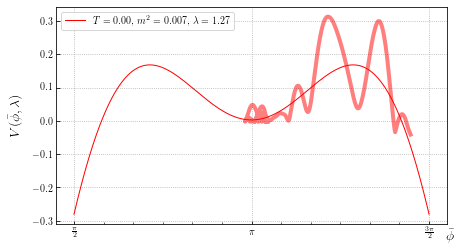

1.297735834050612 0.9952143252527427 1.3488221531596964
Bare mass, curvature mass, lattice reno mass: 0.01 0.00738199140623264 0.007975083226439155


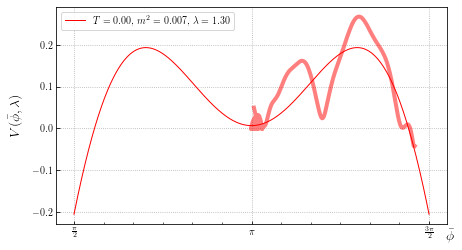

In [ ]:
for ii in range(len(rollrecoList)):
    fig, ax = plt.subplots(1, 1, figsize = (7, 4))
    extphi = np.linspace(phieq/2., np.pi*3./2., 800)
    cmap1 = get_cmap(5)
    cmapsp = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
    cych = cycle([cmap1(0), 'forestgreen', 'orangered', cmapsp[4]])

    col = next(cych)

    tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]
    Vfvofrofphi = Vfvofrofphi - Vfvofrofphi[np.argmin(np.abs(phifv-np.pi))]

    plt.plot(phifv, Vfvofrofphi, color=col, alpha=0.5, linewidth=4)

    xlist = phifv
    curve = Vfvofrofphi
    popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)

    curve2 = Vfvofrofphi*(4.*nu)
    popt2, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve2)
    spline = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt2))
    seconder = scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

    print(*popt)
    print('Bare mass, curvature mass, lattice reno mass:', m2(lamb), seconder, m2reno())
    plt.plot(extphi, fit_to_V(extphi, *popt), color=col, linewidth=1, label=r'$T=%5.2f, \, m^2=%5.3f, \, \lambda=%5.2f$'%(temp, seconder, popt[0]))

    extpos = extphi[extphi>phieq]
    aM = np.argmax(fit_to_V(extpos, *popt))

    if ii==0:
        plt.plot(extphi, V2(extphi, lamb)-1., ls=('--' if lamb==1.5 else '-'), linewidth=2, color='k', label=r'${\rm Bare: \,}$'+r'$m^2=%5.3f, \, \lambda=%5.1f, m^2_{\rm reno}=%5.3f$'%(m2(lamb),lamb,m2reno()))
        plt.plot(extphi, V2(extphi, popt[0])-1., ls=('--' if lamb==1.5 else '-'), linewidth=2, color='forestgreen', label=r'${\rm Bare: \,}$'+r'$\lambda=%5.1f$'%(popt[0]))


    plt.grid(True, ls=':', color='darkgray')
    plt.xlabel(r'$\bar{\phi}$'); plt.ylabel(r'$V(\bar{\phi}, \lambda)$')
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")
    ax.xaxis.set_label_coords(1.01, -0.02)
    plt.legend()
    plt.savefig('./data/effectiveV_bounce_reconstruction.pdf', rasterize=True)
    plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

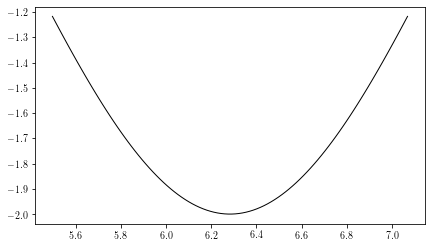

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))
extphi = np.linspace(3.5/2.*np.pi, 4.5/2.*np.pi, 100)

for ii in range(len(rollrecoList)):
   # if ii==0 or ii==1: continue
    col = next(cych)

    tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vrollofrofphi = rollrecoList[ii]
    tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]

    if lamb==1.5 or temp==0.15: continue
    if ii==1:
        plt.plot(extphi, V2(extphi, lamb)-1., ls='-', linewidth=1, color='k', label=r'${\rm Bare \, potential: \,}$'+r'$\lambda=%5.1f, \, m^2=%5.3f$'%(lamb, m2(lamb)))
        
    #plt.plot(phiroll, Vrollofrofphi, color=col, alpha=0.5, linewidth=4)

    xlist = phiroll
    curve = Vrollofrofphi
    popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)

    curve2 = Vrollofrofphi*(4.*nu)
    popt2, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve2)
    spline = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt2))
    seconder = scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

    print(*popt)
    plt.plot(extphi, fit_to_V(extphi, *popt), color=col, label=r'$T=%5.2f, \, m^2=%5.3f, \, \lambda=%5.2f$'%(temp, seconder, popt[0]))

plt.grid(True, ls=':', color='darkgray')
plt.xlabel(r'$\bar{\phi}$'); plt.ylabel(r'$V(\bar{\phi}, \lambda)$')
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.xaxis.set_label_coords(1.01, -0.02)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))
extphi = np.linspace(phieq*0.8, 2.*np.pi*1.1, 100)

for ii in range(len(rollrecoList)):
    col = next(cych)

    tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vrollofrofphi = rollrecoList[ii]
    tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]
    

    if lamb==1.5 or temp==0.15: continue
    if ii==1:
        plt.plot(extphi, V2(extphi, lamb)-1., ls='-', linewidth=1, color='k', label=r'${\rm Bare \, potential: \,}$'+r'$\lambda=%5.1f, \, m^2=%5.3f$'%(lamb, m2(lamb)))

    plt.plot(phiroll, Vrollofrofphi, color=col, alpha=0.3, linewidth=4)
    plt.plot(phifv, Vfvofrofphi, color=col, alpha=0.3, linewidth=4)

    xlist = np.concatenate((phifv, phiroll))
    curve = np.concatenate((Vfvofrofphi, Vrollofrofphi))
    popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)

    curve2 = np.concatenate((Vfvofrofphi, Vrollofrofphi))*(4.*nu)
    popt2, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve2)
    spline = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt2))
    seconder = scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

    print(*popt)    
    plt.plot(extphi, fit_to_V(extphi, *popt), color=col, label=r'$T=%5.2f, \, m^2=%5.3f, \, \lambda=%5.2f$'%(temp, seconder, popt[0]))

plt.grid(True, ls=':', color='darkgray')
plt.xlabel(r'$\bar{\phi}$'); plt.ylabel(r'$V(\bar{\phi}, \lambda)$')
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.xaxis.set_label_coords(1.01, -0.02)
plt.legend()
plt.show()